In [1]:
# TBC
# how do we decide where to calibrate the model on the accuracy/fairness curve?
# what's the impact of transformations on model accuracy?

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

import sys
sys.path.append('../../../utils')

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.datasets import GermanDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_german

from IPython.display import Markdown, display

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[LFR]'


### Read modelling dataset

In [3]:
orig_dataset = GermanDataset(protected_attribute_names=['sex', 'age'])

In [4]:
# fix labels to be 0s and 1s
# originally, 2 = bad credit, 1 = good credit
orig_dataset.labels = np.where(orig_dataset.labels == 2, 0, 1)

In [5]:
orig_dataset.unfavorable_label = 0.0

In [6]:
# check distribution of classes
df_og = orig_dataset.convert_to_dataframe()[0]
df_og['credit'].value_counts()

1.0    700
0.0    300
Name: credit, dtype: int64

In [7]:
# 70:30 split into train, test
# 50:50 split of test into valid, test
dataset_train, dataset_test = orig_dataset.split([0.7], shuffle=True)
# dataset_valid, dataset_test = dataset_vt.split([0.5], shuffle=True)

In [8]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_train.favorable_label, dataset_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_train.privileged_protected_attributes, 
      dataset_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_train.feature_names)

#### Training Dataset shape

(700, 58)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex', 'age']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'sex', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A101', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'property=A124', 'installment_plans=A141', 'installment_plans=A142', 'installment_plans=A143', 'housing=A151', 'housing=A152', 'housing=A153', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'skill_level=A174', 'telephone=A191', 'telephone=A192', 'fore

### Modelling: Logistic

#### Train

In [9]:
scale_orig = StandardScaler()

# scale values, setup training data
X_train = scale_orig.fit_transform(dataset_train.features)
y_train = dataset_train.labels.ravel()
w_train = dataset_train.instance_weights.ravel()

# train logistic model
logreg = LogisticRegression().fit(X_train, y_train, sample_weight=w_train)
y_train_pred = logreg.predict(X_train) #this seems wrong

In [10]:
# dataset_train --> dataset_train_pred
dataset_train_pred = dataset_train.copy()
dataset_train_pred.labels = y_train_pred

In [11]:
# accuracy score
(y_train_pred == y_train).sum()/len(y_train)

0.8057142857142857

#### Valid

In [12]:
# dataset_valid --> dataset_valid_pred
# dataset_valid_pred = dataset_valid.copy(deepcopy=True)
# X_valid = scale_orig.transform(dataset_valid_pred.features)
# y_valid = dataset_valid_pred.labels

# get preds for obs being in risk group 1
# pos_ind = 1
# dataset_valid_pred.scores = logreg.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
# y_valid_pred = dataset_valid_pred.scores

In [13]:
def find_metrics(labels, preds, thresh=None, print_results=True):
    if thresh == None:
        thresh = np.mean(labels)
    
    y_preds = np.where(preds > thresh, 1, 0)
    
    bal_acc = balanced_accuracy_score(labels, y_preds)
    acc = accuracy_score(labels, y_preds)
    prec_score = precision_score(labels, y_preds)
    rec_score = recall_score(labels, y_preds)
    
    if print_results:
        print("The mean threshold of the model is %f " % (thresh))
        print("The accuracy score of the model is %s" % acc)
        print("The balanced accuracy score of the model is %s" % bal_acc)
        print("Precision: %s" % prec_score)
        print("Recall: %s" % rec_score)
    
    return bal_acc, thresh

In [14]:
# valid_bal_acc, valid_best_thresh = find_metrics(y_valid, y_valid_pred)

#### Test

In [15]:
# dataset_test --> dataset_test_pred
dataset_test_pred = dataset_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_test_pred.features)
y_test = dataset_test_pred.labels

# get preds for obs being in risk group 1
pos_ind = 1
dataset_test_pred.scores = logreg.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
y_test_pred = dataset_test_pred.scores

In [16]:
find_metrics(y_test, y_test_pred)

The mean threshold of the model is 0.683333 
The accuracy score of the model is 0.6966666666666667
The balanced accuracy score of the model is 0.6961489088575097
Precision: 0.8313953488372093
Recall: 0.697560975609756


(0.6961489088575097, 0.6833333333333333)

### Find optimal classification threshold for logistic model

#### Test dataset

In [17]:
# sklearn metrics
num_thresh = 100
ba_arr_skl = np.zeros(num_thresh)
thresh_arr_skl = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    ba_arr_skl[idx], thresh_arr_skl[idx] = find_metrics(y_test, y_test_pred, thresh=class_thresh, print_results=False)
    
best_ind_skl = np.where(ba_arr_skl == np.max(ba_arr_skl))[0][0]
best_class_thresh = class_thresh_arr[best_ind_skl]

print("Best balanced accuracy = %.4f" % np.max(ba_arr_skl))
print("Optimal classification threshold = %.4f" % best_class_thresh)

Best balanced accuracy = 0.7135
Optimal classification threshold = 0.7524


In [18]:
# labels = ['TN' ,'FP' ,'FN' ,'TP']
# categories = ['0', '1']
# thresh = np.mean(y_test)

# cm = confusion_matrix(y_test, np.where(y_test_pred > thresh, 1, 0).ravel())
# arr = np.array(cm)

# make_confusion_matrix(arr, group_names=labels, categories=categories, figsize=(5,5), sum_stats=True)

In [19]:
privileged_groups = [{'sex': 1, 'age': 1}]
unprivileged_groups = [{'sex': 0, 'age': 0}]

# select datasets
d1 = dataset_test
d2 = dataset_test_pred

In [20]:
# aif360 metrics
num_thresh = 100
ba_arr = np.zeros(num_thresh)
thresh_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    # labels = y_test, scores = y_preds
    fav_inds = d2.scores > class_thresh
    d2.labels[fav_inds] = d2.favorable_label
    d2.labels[~fav_inds] = d2.unfavorable_label

    metrics_valid = ClassificationMetric(d1, d2, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

    thresh_arr[idx] = class_thresh
    ba_arr[idx] = 0.5*(metrics_valid.true_positive_rate()+metrics_valid.true_negative_rate())
    
# best threshold is where accuracy is max
best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_bal_acc = np.max(ba_arr)
best_class_thresh = class_thresh_arr[best_ind]

print("Step 1: Baseline (no reweighing)")
print("Best balanced accuracy = %.6f" % np.max(ba_arr))
print("Optimal classification threshold = %.4f" % best_class_thresh)

Step 1: Baseline (no reweighing)
Best balanced accuracy = 0.713479
Optimal classification threshold = 0.7524


### Train on transformed data

In [21]:
dataset_transf = pd.read_csv('../../data/german-transformed.csv')

In [22]:
dataset_transf = BinaryLabelDataset(df=dataset_transf, label_names=['credit'], 
                             protected_attribute_names=['sex', 'age'],
                             favorable_label=1, unfavorable_label=0)

In [23]:
# 70:30 split into train, test
# 50:50 split of test into valid, test
dataset_transf_train, dataset_transf_test = dataset_transf.split([0.7], shuffle=True)
# dataset_transf_valid, dataset_transf_test = dataset_transf_vt.split([0.5], shuffle=True)

#### Train

In [24]:
scale_transf = StandardScaler()
X_train_transf = scale_transf.fit_transform(dataset_transf_train.features)
y_train_transf = dataset_transf_train.labels.ravel()
w_train_transf = dataset_transf_train.instance_weights.ravel()

logreg = LogisticRegression().fit(X_train_transf, y_train_transf, sample_weight=w_train_transf)
y_train_pred = logreg.predict(X_train_transf)

#### Test

In [25]:
dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)

X_test_transf = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test_transf = dataset_transf_test_pred.labels

# prob of predicting obs to be in risk group 1
pos_ind = 1
dataset_transf_test_pred.scores = logreg.predict_proba(X_test_transf)[:,pos_ind].reshape(-1,1)
y_test_preds_transf = dataset_transf_test_pred.scores

In [26]:
find_metrics(y_test_transf, y_test_preds_transf)

The mean threshold of the model is 0.693333 
The accuracy score of the model is 0.7
The balanced accuracy score of the model is 0.6896948160535117
Precision: 0.8277777777777777
Recall: 0.7163461538461539


(0.6896948160535117, 0.6933333333333334)

In [27]:
# thresh = np.mean(y_test)

# # tn, fp, fn, tp
# cm = confusion_matrix(y_test, np.where(y_preds_test > thresh, 1, 0).ravel())
# arr = np.array(cm)

# labels = ['TN' ,'FP' ,'FN' ,'TP']
# categories = ['0', '1']

# make_confusion_matrix(arr, group_names=labels, categories=categories, figsize=(5,5))

## Tradeoffs

### Compute fairness metrics at optimal classification threshold

In [28]:
from IPython.display import Markdown, display
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [29]:
d1 = dataset_test
d2 = dataset_test_pred

In [30]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr = []
mean_diff_arr = []
avg_odds_arr = []
disp_imp_arr = []
indiv_fair_arr = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = d2.scores > thresh
    d2.labels[fav_inds] = d2.favorable_label
    d2.labels[~fav_inds] = d2.unfavorable_label
    
    metrics_test = ClassificationMetric(d1, d2,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
    
    bal_acc = 0.5*(metrics_test.true_positive_rate()+metrics_test.true_negative_rate())
    bal_acc_arr.append(bal_acc)
    
    mean_diff_arr.append(metrics_test.mean_difference())    
    avg_odds_arr.append(metrics_test.average_odds_difference())
    disp_imp_arr.append(metrics_test.disparate_impact())
    indiv_fair_arr.append(metrics_test.consistency(n_neighbors=5))

#### Predictions from original testing data

  9%|▉         | 9/100 [00:00<00:01, 86.36it/s]

Classification threshold used = 0.7524


100%|██████████| 100/100 [00:01<00:00, 81.73it/s]


### Transformed dataset

In [31]:
# select datasets
d1 = dataset_transf_test
d2 = dataset_transf_test_pred

In [32]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
mean_diff_arr_transf = []
avg_odds_arr_transf = []
disp_imp_arr_transf = []
indiv_fair_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
        
    # broadcast labels
    d2.labels[fav_inds] = d2.favorable_label
    d2.labels[~fav_inds] = d2.unfavorable_label
    
    metrics_test_transf = ClassificationMetric(d1, d2, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)

    bal_acc = 0.5*(metrics_test_transf.true_positive_rate()+metrics_test_transf.true_negative_rate())
    bal_acc_arr_transf.append(bal_acc)

    mean_diff_arr_transf.append(metrics_test_transf.mean_difference())
    avg_odds_arr_transf.append(metrics_test_transf.average_odds_difference())
    disp_imp_arr_transf.append(metrics_test_transf.disparate_impact())
    indiv_fair_arr_transf.append(metrics_test_transf.consistency(n_neighbors=5))

#### Predictions from transformed testing data

  9%|▉         | 9/100 [00:00<00:01, 88.57it/s]

Classification threshold used = 0.7524


100%|██████████| 100/100 [00:01<00:00, 94.53it/s]


### Visualize tradeoffs

In [33]:
sns.set()

In [34]:
# find points to annotate
best_bal_acc = np.max(bal_acc_arr)
best_class_thresh = class_thresh_arr[np.where(bal_acc_arr == best_bal_acc)[0][0]]

In [35]:
best_mean_diff = mean_diff_arr[np.where(class_thresh_arr == np.float64(best_class_thresh))[0][0]]



In [36]:
best_mean_diff_transf = mean_diff_arr_transf[np.where(class_thresh_arr == np.float64(best_class_thresh))[0][0]]



In [37]:
def plot_tradeoffs(thresholds_array, accuracy_array, fairness_array, transformed_fairness_array, ax, name):
    ax.plot(thresholds_array, accuracy_array)
    ax.set_xlabel('Classification Thresholds', fontsize=10.5)
    ax.set_ylabel('Balanced Accuracy', color='b', fontsize=12, labelpad=15)
    # best_class_thresh used as global variable
    ax.axvline(best_class_thresh, color='k', linestyle=':')

    ax1 = ax.twinx()
    ax1.plot(thresholds_array, fairness_array, color='r', alpha=0.5)
    ax1.set_ylabel(name, color='r', fontsize=12, rotation=-90, labelpad=15)
    ax1.plot(thresholds_array, transformed_fairness_array, color='r')
    
    ax.set_title(name, fontsize=16)
    ax1.legend(['Original', 'Transformed'], loc='lower left')
    ax1.grid(True)

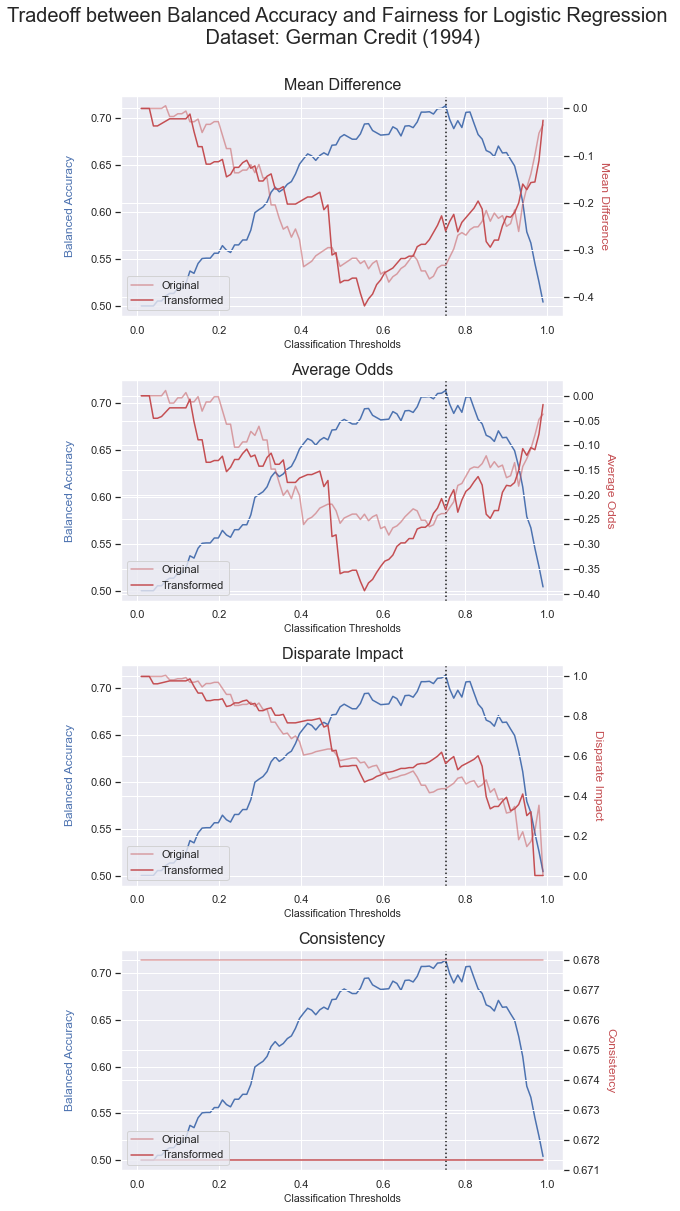

In [38]:
fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(8,16))

plot_tradeoffs(class_thresh_arr, bal_acc_arr, mean_diff_arr, mean_diff_arr_transf, ax=ax[0], name='Mean Difference')

plot_tradeoffs(class_thresh_arr, bal_acc_arr, avg_odds_arr, avg_odds_arr_transf, ax=ax[1], name='Average Odds')

plot_tradeoffs(class_thresh_arr, bal_acc_arr, disp_imp_arr, disp_imp_arr_transf, ax=ax[2], name='Disparate Impact')

plot_tradeoffs(class_thresh_arr, bal_acc_arr, indiv_fair_arr, indiv_fair_arr_transf, ax=ax[3], name='Consistency')

# for ax in fig.get_axes():
#     ax.label_outer()

fig.tight_layout()
# fig.subplots_adjust(hspace=0.25)
fig.suptitle('Tradeoff between Balanced Accuracy and Fairness for Logistic Regression \n Dataset: German Credit (1994)', 
             x=0.5, y=1.05, size=20)
plt.show()